### Load Model Samples

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.journal_run.model_load.load_ssn import load_ssn
from trustworthai.journal_run.model_load.load_punet import load_p_unet
from trustworthai.journal_run.model_load.load_deterministic import load_deterministic
from trustworthai.journal_run.model_load.load_evidential import load_evidential
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch


import numpy as np
from tqdm import tqdm
import scipy.stats
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

import pandas as pd
from trustworthai.analysis.connected_components.connected_comps_2d import conn_comp_2d_analysis
from trustworthai.analysis.evaluation_metrics.challenge_metrics import getAVD, getDSC, getHausdorff, getLesionDetection, do_challenge_metrics
from sklearn import metrics
import math

import torch
import matplotlib.pyplot as plt
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write
from trustworthai.analysis.calibration.helper_funcs import *
from tqdm import tqdm
from trustworthai.utils.logits_to_preds import normalize_samples

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples


# evaluation code
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *
from trustworthai.journal_run.evaluation.new_scripts.model_predictions import *
from trustworthai.analysis.connected_components.connected_comps_2d import *
print("banana")


strawberry
banana


In [2]:
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

In [4]:
ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:57<00:00,  5.08it/s]


In [5]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples

In [6]:
%load_ext autoreload

In [7]:
VOXELS_TO_WMH_RATIO = 382
VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES = 140

In [8]:
class ARGS():
    def __init__(self):
    
        # folder arguments
        self.ckpt_dir = "/home/s2208943/ipdis/results/journal_models/cross_validated_models/"
        self.model_name = "ssn_ens0_cv0"
        self.model_ckpts_folder = "/home/s2208943/ipdis/results/journal_models/cross_validated_models/"
        self.repo_dir = "/home/s2208943/ipdis/WMH_UQ_assessment"
        self.result_dir = "trustworthai/journal_run/evaluation/results/cross_validated_results/out_domain_results"
        self.model_type = "ssn"
        self.uncertainty_type = "ssn"
        
        # data generation arguments
        self.dataset = 'chal'
        self.seed = 3407
        self.test_split = 0.15
        self.val_split = 0.15
        self.empty_slice_retention = 0.1
        
        # general arguments for the loss function
        self.loss_name = 'dice+xent'#'dicev2'#'dice+xent'
        self.dice_factor = 1#5
        self.xent_factor = 1#0.01
        self.xent_weight = 'none'
        self.xent_reweighting=1
        self.dice_empty_slice_weight = 0.5
        self.tversky_beta = 0.7
        self.reduction = 'mean'#'mean_sum'
        
        # evidential arguments
        self.kl_factor=0.1
        self.kl_anneal_count=452*4
        self.use_mle=0
        self.analytic_kl=0

        # p-unet arguments
        self.kl_beta=10.
        self.use_prior_for_dice="false"
        self.punet_sample_dice_coeff=0.05
        self.latent_dim=12

        # ssn arguments
        self.ssn_rank=25
        self.ssn_epsilon=1e-5
        self.ssn_mc_samples=10
        self.ssn_sample_dice_coeff=0.05
        self.ssn_pre_head_layers=32
        
        # training paradigm arguments
        self.lr = 2e-4
        self.dropout_p = 0.1
        self.encoder_dropout1 = 0
        self.encoder_dropout2 = 0
        self.decoder_dropout1 = 0
        self.decoder_dropout2 = 0
        self.max_epochs = 100
        self.early_stop_patience = 15
        self.batch_size = 8#32
        self.cross_validate = "true"
        self.cv_split = 0
        self.cv_test_fold_smooth = 1
        self.weight_decay = 0.0001
        self.overwrite = "true"
        self.no_test_fold = 'false'

In [9]:
args = ARGS()

# sanitise arguments
args.overwrite = True if args.overwrite.lower() == "true" else False
args.cross_validate = True if args.cross_validate.lower() == "true" else False
args.use_prior_for_dice = True if args.use_prior_for_dice.lower() == "true" else False
print(f"CHECKPOINT DIR: {args.ckpt_dir}")
#print(args)


# check if folder exists
model_result_folder = os.path.join(args.repo_dir, args.result_dir)
if not args.overwrite:
    existing_files = os.listdir(model_result_folder)
    for f in existing_files:
        if args.model_name + "_" in f:
            raise ValueError(f"ovewrite = false and model results exist! folder={model_result_folder}, model_name={args.model_name}")
with open(os.path.join(model_result_folder, f"{args.model_name}_init.txt"), "w") as f:
                      f.write("generating results\n")
        
# setup xent reweighting factor
XENT_VOXEL_RESCALE = VOXELS_TO_WMH_RATIO - (1-args.empty_slice_retention) * (VOXELS_TO_WMH_RATIO - VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES)

XENT_WEIGHTING = XENT_VOXEL_RESCALE/2
args.xent_reweighting = XENT_WEIGHTING

CHECKPOINT DIR: /home/s2208943/ipdis/results/journal_models/cross_validated_models/


In [10]:
%autoreload

In [11]:
MODEL_LOADERS = {
    "deterministic":load_deterministic,
    "mc_drop":load_deterministic,
    "evidential":load_evidential,
    "ssn":load_ssn,
    "punet":load_p_unet,
}

MODEL_OUTPUT_GENERATORS = {
    "deterministic":mc_drop_mean_and_samples,
    "mc_drop":mc_drop_mean_and_samples,
    "evidential":evid_mean,
    "ssn":ssn_mean_and_samples,
    "punet":punet_mean_and_samples,
    "ind":ssn_mean_and_samples,
    "ens":ensemble_mean_and_samples,
    "ssn_ens":ssn_ensemble_mean_and_samples,
}

In [12]:
# load the model
model_dir = os.path.join(args.ckpt_dir, args.model_name)  
print("model dir: ", model_dir)
model_raw, loss, val_loss = MODEL_LOADERS[args.model_type](args)
model = load_best_checkpoint(model_raw, loss, model_dir, punet=args.model_type == "punet")

model dir:  /home/s2208943/ipdis/results/journal_models/cross_validated_models/ssn_ens0_cv0


In [13]:
from trustworthai.journal_run.evaluation.new_scripts.model_predictions import *

In [14]:
from torch.utils.data import Dataset

class LimitedSizeDataset(Dataset):
    def __init__(self, base_dataset, start, end):
        super().__init__()
        self.base_dataset = base_dataset
        self.start = start
        self.end = end
        
    def __len__(self):
        return self.end - self.start
    
    def __getitem__(self, idx):
        if idx + self.start >= self.end:
            raise IndexError
        return self.base_dataset[idx + self.start], None # returns none for the y label. Nice.

In [15]:
import numpy as np

In [16]:
def write_results_to_disk(args, IDs, ent_maps, means, output_dir="/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/"):
    # create the output folder
    # output_dir = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/"
    model_name = args.uncertainty_type

    try:
        os.makedirs(output_dir + model_name)
    except FileExistsError:
        print("folder already exists")
    
    # write each file of combined outputs to disk. Nice.
    for i in tqdm(range(len(IDs)), position=0, leave=True):
        ID = IDs[i]
        ent = ent_maps[i]
        pred = torch.nn.functional.softmax(means[i].cuda(), dim=1)[:,1]
        seg = (pred > 0.5)
        np.savez_compressed(f"{output_dir}{model_name}/{ID}_out_maps.npz", ent=ent, pred=pred.cpu(), seg=seg.cpu())


In [17]:
start = 260
end = 300
# while end < 300:
ds = LimitedSizeDataset(ADNI_ds, start=start, end=end)
IDs = ADNI_ds.getIDs()[start:end]

start = end
end += 10

# get predictions
means, samples, misc = get_means_and_samples(model_raw, ds, num_samples=10, model_func=MODEL_OUTPUT_GENERATORS[args.uncertainty_type], args=args)

# get uncertainty maps
ent_maps = get_uncertainty_maps(means, samples, misc, args)

# write results
# write_results_to_disk(args, IDs, ent_maps, means)

  0%|                                                                                                                                                                  | 0/40 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 30/40 [00:11<00:03,  2.63it/s]


ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.91it/s]


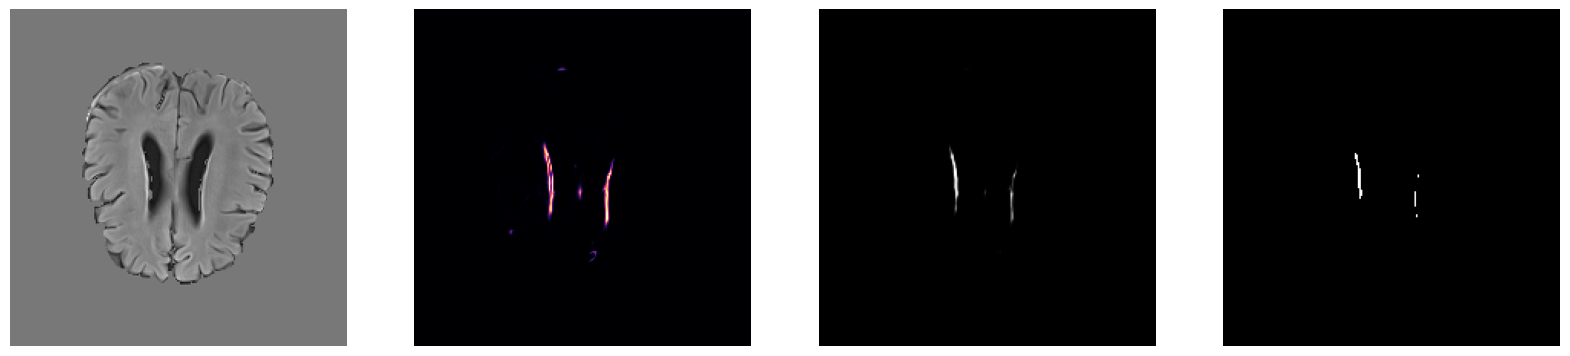

In [49]:
pos = 0
islice = 35
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.imshow(ds[pos][0][0][islice], cmap='gray'); plt.axis('off');
plt.subplot(1,4,2)
plt.imshow(ent_maps[pos][islice], cmap='magma'); plt.axis('off');
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(means[pos][islice], dim=0)[1], cmap='gray'); plt.axis('off');
plt.subplot(1,4,4)
plt.imshow(means[pos][islice].argmax(dim=0), cmap='gray'); plt.axis('off');

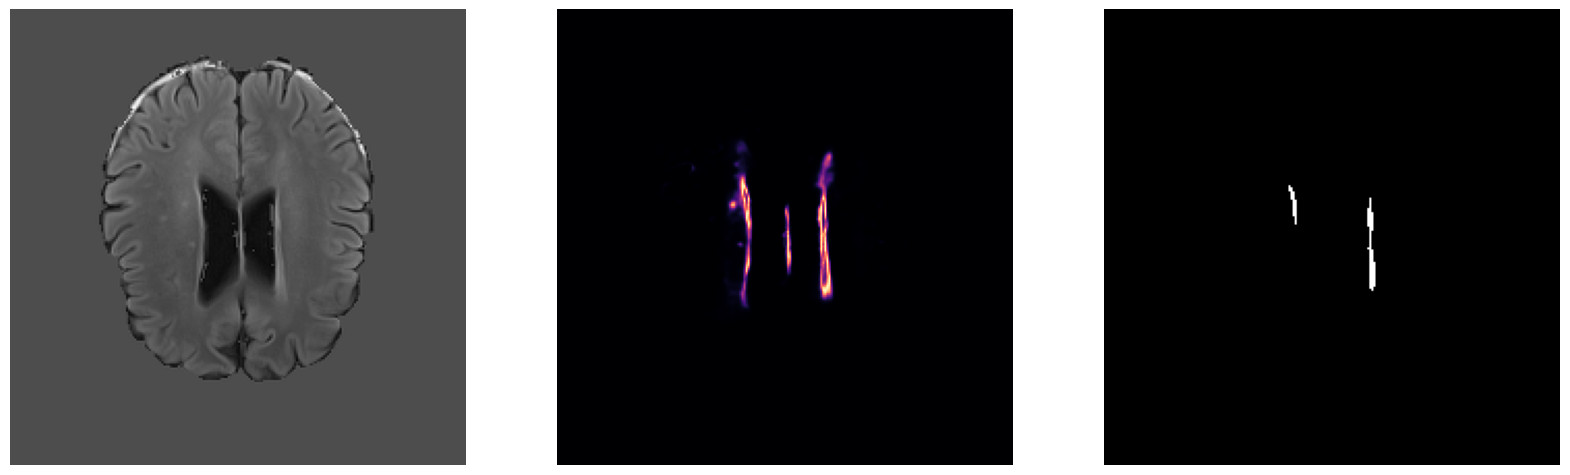

In [50]:
pos = 4
islice = 35
plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
plt.imshow(ds[pos][0][0][islice], cmap='gray'); plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(ent_maps[pos][islice], cmap='magma'); plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(means[pos][islice].argmax(dim=0), cmap='gray'); plt.axis('off');